# Plynty Bureau of Labor Statistics Consumer Expenditure Analysis

[BLS Comsumer Expenditure Survey](https://www.bls.gov/cex/home.htm)

[Interview Data Dictionary](https://www.bls.gov/cex/2015/csxintvwdata.pdf)

[Diary Data Dictionary](https://www.bls.gov/cex/2015/csxdiarydata.pdf)

### Where to download the BLS CE PUMD
- The zip files download automatically
- To download the Stub files open the links then right click and choose "Save As..."

[2015 interview zip file](https://www.bls.gov/cex/pumd/data/comma/intrvw15.zip)

[2015 diary zip file](https://www.bls.gov/cex/pumd/data/comma/diary15.zip)

[2015 IntStub file](https://www.bls.gov/cex/pumd/2014/csxintstub.txt)

[2015 IStub file](https://www.bls.gov/cex/pumd/2014/csxistub.txt)

[2015 DStub file](https://www.bls.gov/cex/pumd/2014/csxdstub.txt)

### This Scripts Goals for Plynty
- Create an easy to use analysis script for the BLS CE PUMD 
- Create a csv files that has average percentages spent on plynty categories for certain income classes
- Compare the Family CUs vs the Single person CUs

##### Importing Libraries 

In [1]:
import pandas as pd
import numpy as np
import os
import subprocess
import math
import matplotlib.pyplot as plt
from scipy.interpolate import *
from plyntywidgets import *
from blsFunctions import *
print("Dependencies Loaded...")

Dependencies Loaded...


### Setting Parameters
- year: the last two number associated with the year of the data
    for example for data from 2015: year = "15"
- minAge: the low bound (inclusive) of the age range you wish to subset by
- maxAge: the high bound (inclusive) of the age range you wish to subset by
- incomeBrackets: array of numbers that you wish to create the new income classes
    the bracketing works as follows (1,2], (2,3], (3,4]
- filesToRead: the strings of the abbreviations associated with the files you wish to read
    options are: "all", "diary", "interview", "dtbd", "expd", "fmld", "memd", "fmli", "itbi", "memi", "mtbi", "ntaxi"

In [2]:
year = "15"
filesToRead = ["fmli", "mtbi"]
incomeBrackets = [-10000000, 10000, 20000, 40000, 60000, 80000, 90000, 130000, 160000, 240000, 9990000]
minAge = 60
maxAge = 75

### Setting Directory locations and FileNames on your Local Machine

In [3]:
# directory in which the diary and interview folders are held is located
diaryDir = "/Users/adyke/Vizuri/CE_PUMD/diary15/"
interviewDir = "/Users/adyke/Vizuri/CE_PUMD/intrvw15/"

# Directory where stubfiles are located
pathToStubFileDir = "/Users/adyke/Vizuri/Stubfiles/"
rScriptStubfilePathAndName = "/Users/adyke/Vizuri/BLS_Python_Analysis/creatingStubCsvs.R"

# Filenames of the Stubfiles
IStubFileName = "IStub2015.txt"
DStubFileName = "DStub2015.txt"
IntStubFileName = "IntStub2015.txt"

# name of interview dir within the interview dir
insideIntrvwDirName = "intrvw"

# name of the directory where you want the output percentages csv
outputDir = "/Users/adyke/Vizuri/outputFiles/"

### Reading in the files specified by FilesToRead

In [4]:
if(len(filesToRead)==0):
    print("The files to read variable is empty.")

# looping through each file to read
for file in filesToRead:
    if file == "dtbd" or file == "all" or file == "diary":
        dtbd = readFileSet("dtbd", diaryDir)
    if file == "expd" or file == "all" or file == "diary":
        expd = readFileSet("expd", diaryDir)
    if file == "fmld" or file == "all" or file == "diary":
        fmld = readFileSet("fmld", diaryDir)
    if file == "memd" or file == "all" or file == "diary":
        memd = readFileSet("memd", diaryDir)
    if file == "fmli" or file == "all" or file == "interview":
        fmli = readFileSet("fmli", interviewDir+insideIntrvwDirName+year+"/")
    if file == "itbi" or file == "all" or file == "interview":
        itbi = readFileSet("itbi", interviewDir+insideIntrvwDirName+year+"/")
    if file == "itii" or file == "all" or file == "interview":
        itii = readFileSet("itii", interviewDir+insideIntrvwDirName+year+"/")
    if file == "memi" or file == "all" or file == "interview":
        memi = readFileSet("memi", interviewDir+insideIntrvwDirName+year+"/")
    if file == "mtbi" or file == "all" or file == "interview":
        mtbi = readFileSet("mtbi", interviewDir+insideIntrvwDirName+year+"/")
        mtbi.UCC = mtbi.UCC.astype(str)
    if file == "ntaxi" or file == "all" or file == "interview":
        ntaxi = readFileSet("ntaxi", interviewDir+insideIntrvwDirName+year+"/")
# does not read form the expn or para subdirectories


### Using R to convert the Stub files into csv files

In [5]:
if os.path.isfile(pathToStubFileDir+"DStub.csv") and os.path.isfile(pathToStubFileDir+"IStub.csv") and os.path.isfile(pathToStubFileDir+"IntStub.csv"):
    print("Stubfiles Exist")
else:
    # converting the stub files via R 
    subprocess.call("Rscript "+rScriptStubfilePathAndName+" "+pathToStubFileDir+" "+IStubFileName+" "+DStubFileName+" "+IntStubFileName, shell=True)
    print("Stubfile Csvs created in "+pathToStubFileDir)

Stubfiles Exist


### Reading and Cleaning the stubfile CSVs into pandas dataframes

In [6]:
# reading in the stubfiles
DStub = pd.read_csv(pathToStubFileDir+"DStub.csv")
IStub = pd.read_csv(pathToStubFileDir+"IStub.csv")
IntStub = pd.read_csv(pathToStubFileDir+"IntStub.csv")

# removing the index from the stufile
DStub = DStub.drop(DStub.columns[0], axis=1)
IStub = IStub.drop(IStub.columns[0], axis=1)
IntStub = IntStub.drop(IntStub.columns[0], axis=1)

# replacing * with 0 in the level columns
DStub.loc[DStub.level == "*", 'level'] = 0
IStub.loc[IStub.level == "*", 'level'] = 0
IntStub.loc[IntStub.level == "*", 'level'] = 0

# Starting the Plynty calculations

### Creating the UCC roll ups for Plynty

In [7]:
# creating UCC rollups for the interview files for plynty categories
iTotalExp = categoricalUCCRollUp(IStub,["TOTALE"])
iFoodAtHome = categoricalUCCRollUp(IStub, ["FOODHO", "ALCHOM"])
iFoodAway = categoricalUCCRollUp(IStub, ["FOODAW", "ALCAWA"])
iHousing = categoricalUCCRollUp(IStub, ["HOUSIN"], ignoreUCCs = categoricalUCCRollUp(IStub, ["UTILS"]))
iUtilites = categoricalUCCRollUp(IStub, ["UTILS"])
iClothingAndBeauty = categoricalUCCRollUp(IStub, ["APPARE","PERSCA"])
iTransportation = categoricalUCCRollUp(IStub, ["TRANS"])
iHealthcare = categoricalUCCRollUp(IStub, ["HEALTH"])
iEntertainment = categoricalUCCRollUp(IStub, ["ENTRTA","READIN"])
iMiscellaneous = categoricalUCCRollUp(IStub, ["MISC","TOBACC"])
iCharitableAndFamilyGiving = categoricalUCCRollUp(IStub, ["CASHCO"])
iInsurance = categoricalUCCRollUp(IStub, ["LIFEIN"])
iEducation = categoricalUCCRollUp(IStub, ["EDUCAT"])
iHousingPrinciple = categoricalUCCRollUp(IStub,["MRTPRI"])

### Adding and Rolling up the MTBI Categories into mtbiRolledUp

outputs from cell:
- mtbiTrimmed: Dataframe with NewID, TotatlExp and each entry of cost.

In [8]:
rollupNames = ["iTotalExp","iFoodAtHome","iFoodAway","iHousing","iUtilites","iClothingAndBeauty","iTransportation","iHealthcare","iEntertainment","iMiscellaneous","iCharitableAndFamilyGiving","iInsurance","iEducation","iHousingPrinciple"]
rollups = [iTotalExp,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple]

mtbiRolledUp = rollUpDataframe(mtbi, rollupNames, rollups, negativeColumns=["iHousingPrinciple"], multiple=4)

mtbiTrimmed = mtbiRolledUp.loc[: , ['NEWID','iTotalExp','iFoodAtHome','iFoodAway','iHousing','iUtilites','iClothingAndBeauty','iTransportation','iHealthcare','iEntertainment','iMiscellaneous','iCharitableAndFamilyGiving','iInsurance','iEducation','iHousingPrinciple']]

### Creating the Sum for all expenditure category columns for each NEWID
nonZeroColumns is an array that contains the names of columns that should not be Zero

outputs from cell:
- iExpensesByNewID: total expenses for each category for each NewID

In [9]:
# adding up all columns for each new id
iExpensesByNewID = mtbiTrimmed.groupby(['NEWID'],as_index=False).sum()
# removing rows with zero values in key categories
nonZeroColumns = ['iFoodAtHome','iFoodAway','iHousing','iUtilites']
for column in nonZeroColumns:
    iExpensesByNewID = iExpensesByNewID[iExpensesByNewID[column] != 0]
iExpensesByNewID['iHousing'] = iExpensesByNewID['iHousing']+iExpensesByNewID['iHousingPrinciple']

### Subestting FMLI for age and recoding the incomebrackets

In [10]:
# subsetting for the age bracket
fmliAge = subsetDataframe(dataframe=fmli, columnName="AGE_REF", minValue=minAge, maxValue=maxAge)
fmliAge = fmliAge.reset_index()

# recoding the income brackets
fmliRecoded = binColumn(dataframe=fmliAge, toBinColumnName="FINCBTXM", binValues=incomeBrackets, binnedColumnName="INCLASS", labels=range(1,len(incomeBrackets)))

### Subsetting for Single person CU and Family CU
- should the subsetting be for family size or should it be for single parents?

In [11]:
# Family
fmliRecodedFamily = fmliRecoded.loc[fmliRecoded.FAM_SIZE > 1]
# Single
fmliRecodedSingle = fmliRecoded.loc[fmliRecoded.FAM_SIZE == 1]

### Adding the Income class colum to the ExpensesByNewID dataframe

In [12]:
# Family
inclassExpensesFamily = pd.merge(left=fmliRecodedFamily[['NEWID','INCLASS','FINCBTXM']],right=iExpensesByNewID, on=['NEWID'])
# Single
inclassExpensesSingle = pd.merge(left=fmliRecodedSingle[['NEWID','INCLASS','FINCBTXM']],right=iExpensesByNewID, on=['NEWID'])

### Averaging the expenditures based on incomebrackets
inclassAverages is average money spent for each incomeclass

In [13]:
# Family
inclassAveragesFamily = round(inclassExpensesFamily.ix[: ,inclassExpensesFamily.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)
# Single
inclassAveragesSingle = round(inclassExpensesSingle.ix[: ,inclassExpensesSingle.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)

### Converting the Average expenditures for income classes into percentages of expenditures
percentages is the percent of total expenditure for each category for each incomeclass 

In [14]:
# creating new dataframe for the percentages that only includes the plynty categories
percentagesFamily = inclassAveragesFamily.loc[:,rollupNames[1:]]
percentagesSingle = inclassAveragesSingle.loc[:,rollupNames[1:]]
for column in rollupNames[1:]:
    percentagesFamily[column] = inclassAveragesFamily[column]/inclassAveragesFamily.iTotalExp
    percentagesSingle[column] = inclassAveragesSingle[column]/inclassAveragesSingle.iTotalExp

# Family
percentagesFamily['ExpInc'] = inclassAveragesFamily['iTotalExp']/inclassAveragesFamily['FINCBTXM']
# Single
percentagesSingle['ExpInc'] = inclassAveragesSingle['iTotalExp']/inclassAveragesSingle['FINCBTXM']

# Family
percentagesFamily.ExpInc.ix[percentagesFamily['ExpInc']>1] = 1
# Single
percentagesSingle.ExpInc.ix[percentagesSingle['ExpInc']>1] = 1

### Removing outliers in iHousing
 - For each income class
    - Find Q1 and Q3
    - Calculate IQR
    - Find rows outside of Q3/Q2 +/- (1.5 x IQR) and Q3/Q2 +/- (3 x IQR)
 - Remove Rows from Dataframe
 - Clean1: Inner Fence
 - Clean2: Outer Fence

In [15]:
# # Family or Single
# outliersFamily = inclassExpensesFamily.copy()
# outliersSingle = inclassExpensesSingle.copy()

# # Family or Single
# outerFenceFamily = []
# outerFenceSingle = []

# for inclass in range(1,len(incomeBrackets)):
#     # Family or Single
#     outliersInClassFamily = outliersFamily.where(outliersFamily['INCLASS']==inclass)
#     Q1 = outliersInClassFamily['iHousing'].quantile(0.25)
#     Q3 = outliersInClassFamily['iHousing'].quantile(0.75)
#     IQR = Q3 - Q1
#     outerFenceFamily.extend(outliersInClassFamily[outliersInClassFamily['iHousing'] < (Q1 - (3 * IQR))].index.tolist())
#     outerFenceFamily.extend(outliersInClassFamily[outliersInClassFamily['iHousing'] > (Q3 + (3 * IQR))].index.tolist())
    
#     outliersInClassSingle = outliersSingle.where(outliersSingle['INCLASS']==inclass)
#     Q1 = outliersInClassSingle['iHousing'].quantile(0.25)
#     Q3 = outliersInClassSingle['iHousing'].quantile(0.75)
#     IQR = Q3 - Q1
#     outerFenceSingle.extend(outliersInClassSingle[outliersInClassSingle['iHousing'] < (Q1 - (3 * IQR))].index.tolist())
#     outerFenceSingle.extend(outliersInClassSingle[outliersInClassSingle['iHousing'] > (Q3 + (3 * IQR))].index.tolist())


# # Family or Single
# cleanFamily = outliersFamily.drop(outliersFamily.index[outerFenceFamily])
# cleanSingle = outliersSingle.drop(outliersSingle.index[outerFenceSingle])

In [16]:
# Family or Single
outliersFamily = inclassExpensesFamily.copy()
outliersSingle = inclassExpensesSingle.copy()

# Family or Single
outerFenceFamily = []
outerFenceSingle = []

for column in outliersFamily.columns[4:len(outliersFamily.columns)-1]:
    # Family or Single
    Q1 = outliersFamily[column].quantile(0.25)
    Q3 = outliersFamily[column].quantile(0.75)
    IQR = Q3 - Q1
    outerFenceFamily.extend(outliersFamily[outliersFamily[column] < (Q1 - (3 * IQR))].index.tolist())
    outerFenceFamily.extend(outliersFamily[outliersFamily[column] > (Q3 + (3 * IQR))].index.tolist())
    
    Q1 = outliersSingle[column].quantile(0.25)
    Q3 = outliersSingle[column].quantile(0.75)
    IQR = Q3 - Q1
    outerFenceSingle.extend(outliersSingle[outliersSingle[column] < (Q1 - (3 * IQR))].index.tolist())
    outerFenceSingle.extend(outliersSingle[outliersSingle[column] > (Q3 + (3 * IQR))].index.tolist())
    
# Family or Single
cleanFamily = outliersFamily.drop(outliersFamily.index[outerFenceFamily])
cleanSingle = outliersSingle.drop(outliersSingle.index[outerFenceSingle])

### Creating the percentage output for cleaned dataframe

In [17]:
# Family
inclassCleanAveragesFamily = round(cleanFamily.ix[: ,cleanFamily.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)
# creating new dataframe for the percentages that only includes the plynty categories
cleanPercentagesFamily = inclassCleanAveragesFamily.loc[:,rollupNames[1:]]
for column in rollupNames[1:]:
    cleanPercentagesFamily[column] = inclassCleanAveragesFamily[column]/inclassCleanAveragesFamily.iTotalExp
cleanPercentagesFamily['ExpInc'] = inclassCleanAveragesFamily['iTotalExp']/inclassCleanAveragesFamily['FINCBTXM']
# truncate the max ExpInc
cleanPercentagesNonTruncatedFamily = cleanPercentagesFamily.copy()
cleanPercentagesFamily.ExpInc.ix[cleanPercentagesFamily['ExpInc']>1] = 1
# cleanPercentagesFamily

# Single
inclassCleanAveragesSingle = round(cleanSingle.ix[: ,cleanSingle.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)
# creating new dataframe for the percentages that only includes the plynty categories
cleanPercentagesSingle = inclassCleanAveragesSingle.loc[:,rollupNames[1:]]
for column in rollupNames[1:]:
    cleanPercentagesSingle[column] = inclassCleanAveragesSingle[column]/inclassCleanAveragesSingle.iTotalExp
cleanPercentagesSingle['ExpInc'] = inclassCleanAveragesSingle['iTotalExp']/inclassCleanAveragesSingle['FINCBTXM']
# truncate the max ExpInc
cleanPercentagesNonTruncatedSingle = cleanPercentagesSingle.copy()
cleanPercentagesSingle.ExpInc.ix[cleanPercentagesSingle['ExpInc']>1] = 1
# cleanPercentagesSingle

### Cell that determines how similar the neighbor rows are
Potentially use this to combine similar rows.
Can't figure out the correct statistical test to determine if rows are statistically similar

###### The higher the difference value the more different the rows are. (low values mean similar rows)

# Plots

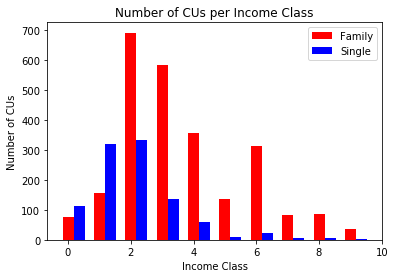

[690 583 355 311 156 136  86  83  76  36]
[331 319 136 114  58  21   9   7   6   3]


In [18]:
plt.close()
n_groups = 3
values1 = cleanFamily.INCLASS.value_counts().values
values2 = cleanSingle.INCLASS.value_counts().values

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1

 
rects1 = plt.bar(cleanFamily.INCLASS.value_counts().index -1, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Family')

rects2 = plt.bar(cleanSingle.INCLASS.value_counts().index - 1 + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Single')

plt.xlabel('Income Class')
plt.ylabel('Number of CUs')
plt.title('Number of CUs per Income Class')
plt.legend()
plt.show()
print(cleanFamily.INCLASS.value_counts().values)
print(cleanSingle.INCLASS.value_counts().values)

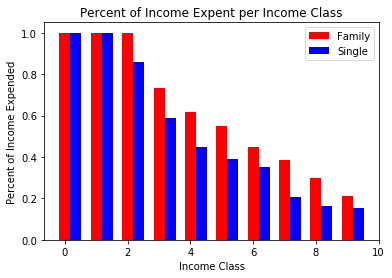

In [19]:
n_groups = 3
values1 = cleanPercentagesFamily.ExpInc
values2 = cleanPercentagesSingle.ExpInc

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1
 
rects1 = plt.bar(cleanPercentagesFamily.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Family')
 
rects2 = plt.bar(cleanPercentagesSingle.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Single')

 
plt.xlabel('Income Class')
plt.ylabel('Percent of Income Expended')
plt.title('Percent of Income Expent per Income Class')
plt.legend()
plt.show()

### Looking at the Family vs Single Healthcare costs
Note: The higher income brackets are not statistically significant for the Single people because there are so few observations (<50)

0.13504256404815956
0.1178643559905537


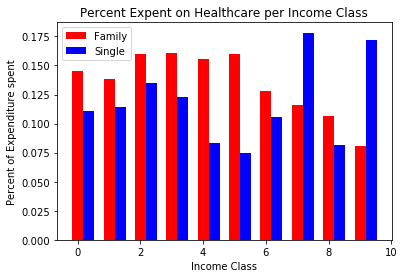

In [20]:
print(cleanPercentagesFamily.iHealthcare.mean())
print(cleanPercentagesSingle.iHealthcare.mean())

n_groups = 3
values1 = cleanPercentagesFamily.iHealthcare
values2 = cleanPercentagesSingle.iHealthcare

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1
 
rects1 = plt.bar(cleanPercentagesFamily.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Family')
 
rects2 = plt.bar(cleanPercentagesSingle.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Single')

 
plt.xlabel('Income Class')
plt.ylabel('Percent of Expenditure spent')
plt.title('Percent Expent on Healthcare per Income Class')
plt.legend()
plt.show()

### Looking at the Family vs Single Transportation costs
Note: The higher income brackets are not statistically significant for the Single people because there are so few observations (<50)

0.12496255439659536
0.10724402219295588


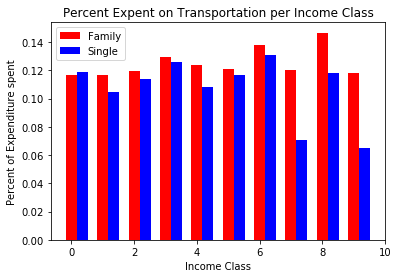

In [21]:
print(cleanPercentagesFamily.iTransportation.mean())
print(cleanPercentagesSingle.iTransportation.mean())

n_groups = 3
values1 = cleanPercentagesFamily.iTransportation
values2 = cleanPercentagesSingle.iTransportation

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1
 
rects1 = plt.bar(cleanPercentagesFamily.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Family')
 
rects2 = plt.bar(cleanPercentagesSingle.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Single')

 
plt.xlabel('Income Class')
plt.ylabel('Percent of Expenditure spent')
plt.title('Percent Expent on Transportation per Income Class')
plt.legend()
plt.show()

### Looking at Single vs Family housing costs

0.3443828338102582
0.4124653416522002


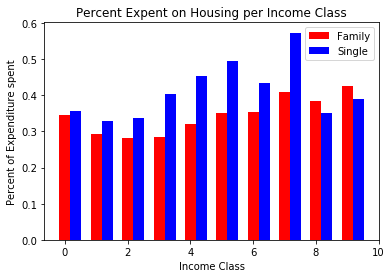

In [22]:
print(cleanPercentagesFamily.iHousing.mean())
print(cleanPercentagesSingle.iHousing.mean())

n_groups = 3
values1 = cleanPercentagesFamily.iHousing
values2 = cleanPercentagesSingle.iHousing

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1
 
rects1 = plt.bar(cleanPercentagesFamily.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Family')
 
rects2 = plt.bar(cleanPercentagesSingle.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Single')

 
plt.xlabel('Income Class')
plt.ylabel('Percent of Expenditure spent')
plt.title('Percent Expent on Housing per Income Class')
plt.legend()
plt.show()

0.13504256404815956
0.1178643559905537


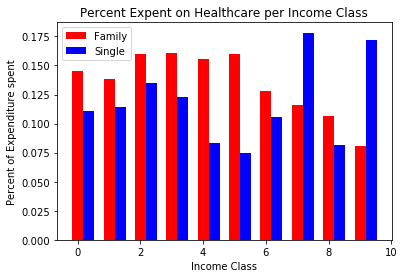

In [23]:
print(cleanPercentagesFamily.iHealthcare.mean())
print(cleanPercentagesSingle.iHealthcare.mean())

n_groups = 3
values1 = cleanPercentagesFamily.iHealthcare
values2 = cleanPercentagesSingle.iHealthcare

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1
 
rects1 = plt.bar(cleanPercentagesFamily.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Family')
 
rects2 = plt.bar(cleanPercentagesSingle.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Single')

 
plt.xlabel('Income Class')
plt.ylabel('Percent of Expenditure spent')
plt.title('Percent Expent on Healthcare per Income Class')
plt.legend()
plt.show()

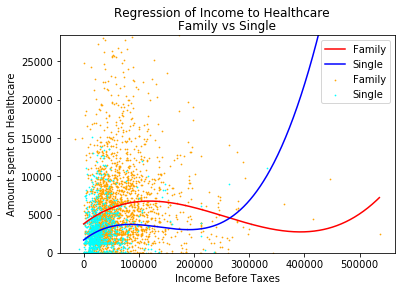

In [24]:
valueFam = cleanFamily.iHealthcare
valueSingle = cleanSingle.iHealthcare

incomeFam = cleanFamily.FINCBTXM
incomeSingle = cleanSingle.FINCBTXM

famCoefficients = np.polyfit(incomeFam, valueFam, deg = 3)
singleCoefficients = np.polyfit(incomeSingle, valueSingle, deg = 3)

famP = np.poly1d(famCoefficients)
singleP = np.poly1d(singleCoefficients)

x = range(0,int(incomeFam.max()),1000)
plt.scatter(incomeFam, valueFam, color='orange', s=.5, label="Family")
plt.scatter(incomeSingle, valueSingle, color='cyan', s=0.5, label="Single")
plt.plot(x,famP(x), color='r',label="Family")
plt.plot(x,singleP(x), color='b', label="Single")
plt.xlabel("Income Before Taxes")
plt.ylabel("Amount spent on Healthcare")
plt.ylim(0,valueFam.max())
plt.suptitle("Regression of Income to Healthcare")
plt.title("Family vs Single")
plt.legend()
plt.show()

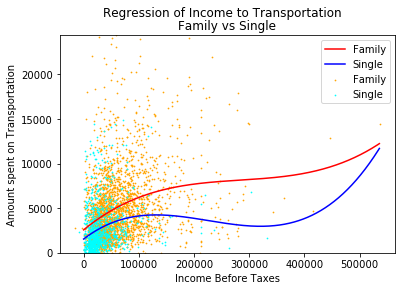

In [25]:
valueFam = cleanFamily.iTransportation
valueSingle = cleanSingle.iTransportation

incomeFam = cleanFamily.FINCBTXM
incomeSingle = cleanSingle.FINCBTXM

famCoefficients = np.polyfit(incomeFam, valueFam, deg = 3)
singleCoefficients = np.polyfit(incomeSingle, valueSingle, deg = 3)

famP = np.poly1d(famCoefficients)
singleP = np.poly1d(singleCoefficients)

x = range(0,int(incomeFam.max()),1000)
plt.scatter(incomeFam, valueFam, color='orange', s=.5, label="Family")
plt.scatter(incomeSingle, valueSingle, color='cyan', s=0.5, label="Single")
plt.plot(x,famP(x), color='r',label="Family")
plt.plot(x,singleP(x), color='b', label="Single")
plt.xlabel("Income Before Taxes")
plt.ylabel("Amount spent on Transportation")
plt.ylim(0,valueFam.max())
plt.suptitle("Regression of Income to Transportation")
plt.title("Family vs Single")
plt.legend()
plt.show()

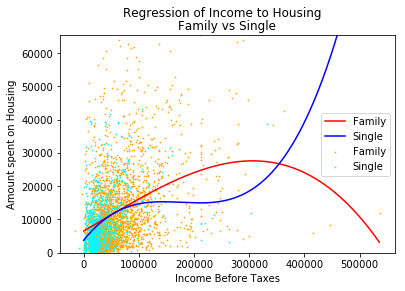

In [26]:
valueFam = cleanFamily.iHousing
valueSingle = cleanSingle.iHousing

incomeFam = cleanFamily.FINCBTXM
incomeSingle = cleanSingle.FINCBTXM

famCoefficients = np.polyfit(incomeFam, valueFam, deg = 3)
singleCoefficients = np.polyfit(incomeSingle, valueSingle, deg = 3)

famP = np.poly1d(famCoefficients)
singleP = np.poly1d(singleCoefficients)

x = range(0,int(incomeFam.max()),1000)
plt.scatter(incomeFam, valueFam, color='orange', s=.5, label="Family")
plt.scatter(incomeSingle, valueSingle, color='cyan', s=0.5, label="Single")
plt.plot(x,famP(x), color='r',label="Family")
plt.plot(x,singleP(x), color='b', label="Single")
plt.legend()
plt.xlabel("Income Before Taxes")
plt.ylabel("Amount spent on Housing")
plt.ylim(0,valueFam.max())
plt.suptitle("Regression of Income to Housing")
plt.title("Family vs Single")
plt.show()

In [27]:
# cleanPercentagesFamily

In [28]:
# cleanPercentagesSingle

In [29]:
(cleanPercentagesSingle.ix[:6] - cleanPercentagesFamily.ix[:6])

,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple,ExpInc
0,-0.007849,0.020395,0.011288,-0.005051,0.002215,0.002263,-0.034382,-0.004846,-0.000823,-0.007990,-0.001076,0.0,-0.025856,0.000000
1,-0.014361,0.002365,0.035769,0.011647,0.000789,-0.012227,-0.023995,-0.001570,0.002165,-0.005844,-0.004000,0.0,-0.009262,0.000000
2,-0.013826,-0.004079,0.056713,-0.006676,-0.001973,-0.006061,-0.024634,0.006612,-0.002937,-0.002058,-0.003930,0.0,-0.002849,-0.141711
3,-0.020220,-0.004231,0.119189,-0.017679,0.001736,-0.003276,-0.037606,0.005856,-0.007343,-0.005804,-0.004884,0.0,0.025739,-0.145516
4,-0.025106,0.007428,0.132794,0.003465,-0.004893,-0.015218,-0.072259,0.004124,-0.004670,-0.011890,-0.004706,0.0,0.009070,-0.168351
5,-0.023443,0.030304,0.145086,-0.024140,0.014343,-0.004217,-0.085188,-0.009191,-0.010937,-0.019229,-0.004575,0.0,0.008814,-0.158182
6,-0.044564,0.006644,0.081492,-0.008756,0.004349,-0.007171,-0.021902,0.013392,-0.001402,-0.008412,-0.003101,0.0,0.010570,-0.097001
